### Practice with GNNs

The purpose of this homework is for you to build intuition about graph neural networks. You will explore three different neural network learning approaches

- A graph autoencoder that uses one-hot encodings for the node feature vector
- A graph convolutional neural network that uses a node feature vector obtained using a transformer
- A graph convolution neural network that includes some training

---

#### The Dataset

We'll construct a smaller dataset from the [Cora dataset](https://paperswithcode.com/dataset/cora). ChatGPT-4o helped with code to subsample this dataset to something more managable.

In [1]:
import pandas as pd
import networkx as nx

# Load node data
column_names = ['paper_id'] + [f'word_{i}' for i in range(1433)] + ['subject']
nodes = pd.read_csv('datasets/cora.content', sep='\t', header=None, names=column_names)
nodes.head()


,paper_id,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,...,word_1424,word_1425,word_1426,word_1427,word_1428,word_1429,word_1430,word_1431,word_1432,subject
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


In [2]:
# Load edge data
edges = pd.read_csv('datasets/cora.cites', sep='\t', header=None, names=['source', 'target'])
edges.head()


,source,target
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [3]:
# Create a directed graph
G: nx.Graph = nx.from_pandas_edgelist(edges, 'source', 'target', create_using=nx.Graph())

# Add node attributes
for _, row in nodes.iterrows():
    G.nodes[row['paper_id']].update(row.to_dict())

Label each node with the subject, or area of publication.

In [4]:
# Create a dictionary mapping paper_id to subject
id_to_subject = dict(zip(nodes['paper_id'], nodes['subject']))

for node in G.nodes:
    if node in id_to_subject:
        G.nodes[node]['subject'] = id_to_subject[node]

G.nodes[35]['subject']  # e.g., 'Neural_Networks'

'Genetic_Algorithms'

In [5]:
import random

def snowball_sample(G_full: nx.Graph, start_node: str, target_size: int) -> nx.Graph:
    visited = set([start_node])
    frontier = set(G_full.neighbors(start_node))
    
    while len(visited) < target_size and frontier:
        next_node = random.choice(list(frontier))
        visited.add(next_node)
        frontier.update(G_full.neighbors(next_node))
        frontier -= visited  # remove already visited nodes
    
    return G_full.subgraph(visited).copy()

In [6]:
random.seed(42)
# Start from a high-degree node
start_node = max(G.degree, key=lambda x: x[1])[0]

# Sample 250 connected nodes
G_sub = snowball_sample(G, start_node=start_node, target_size=250)

Visualize

/var/folders/7n/9nnbl1td6sq50rrh09m9x1v80000gn/T/ipykernel_71006/3734432347.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


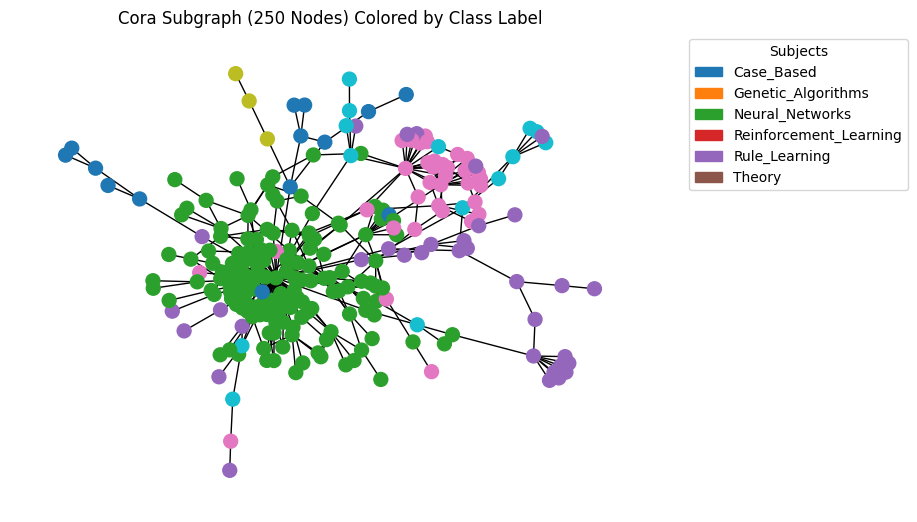

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch

# Map class labels to integers
labels = nx.get_node_attributes(G_sub, 'subject')
unique_labels = sorted(set(labels.values()))
label_to_int = {label: i for i, label in enumerate(unique_labels)}

# Create a color list for the nodes
node_colors = [label_to_int[labels[node]] for node in G_sub.nodes()]

#plt.figure(figsize=(10, 8))
plt.figure()
#pos = nx.nx_pydot.graphviz_layout(G_sub, prog="neato")
pos = nx.spring_layout(G_sub, seed=42)

nx.draw(
    G_sub,
    pos,
    node_color=node_colors,
    cmap=plt.cm.tab10,  # use tab10 or tab20 for distinct colors
    with_labels=False,
    node_size=100
)

# Optional: Create a legend
legend_handles = [Patch(color=plt.cm.tab10(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_handles, title="Subjects", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("Cora Subgraph (250 Nodes) Colored by Class Label")
plt.axis('off')
plt.tight_layout()
plt.show()

---

#### Graph autoencoder

Let's see how well we can do using only a graph autoencoder without node information. We'll use one hot encoding for eachnode. 



In [8]:
import torch
from torch_geometric.data import Data

# Step 1: One-hot encode the 250 nodes in the subgraph
ordered_nodes = list(G_sub.nodes())
num_nodes = len(ordered_nodes)
x = torch.eye(num_nodes)  # Shape: (250, 250), each row is a one-hot vector

# Step 2: Build node ID → index mapping
node_to_index = {node_id: i for i, node_id in enumerate(ordered_nodes)}

# Step 3: Remap edges using index mapping
edges = [
    [node_to_index[src], node_to_index[dst]]
    for src, dst in G_sub.edges()
]
edge_index = torch.tensor(edges, dtype=torch.long).T  # Shape: (2, num_edges)

# Step 4: Map class labels to integers
labels = nx.get_node_attributes(G_sub, 'subject')
unique_labels = sorted(set(labels.values()))
label_to_index = {label: i for i, label in enumerate(unique_labels)}
y = torch.tensor([label_to_index[labels[node]] for node in ordered_nodes], dtype=torch.long)

# Step 5: Create PyG Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Optional: inspect
print(f"x shape: {data.x.shape}, edge_index shape: {data.edge_index.shape}, y shape: {data.y.shape}")

x shape: torch.Size([250, 250]), edge_index shape: torch.Size([2, 366]), y shape: torch.Size([250])


/Users/mike/Dropbox/Mac/Documents/Classes/CS 575/Winter 2025/Code/cs575-homework-1-fall-2025/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define a model with two hidden layers and relu's between the hidden layers. I've made no effort to optimize then number of layers.

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden1)
        self.conv2 = GCNConv(hidden1, hidden2)
        self.conv3 = GCNConv(hidden2, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

Add the training function, which just sequences the steps

In [10]:
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    loss = model.recon_loss(z, data.edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()

Now run the code

In [11]:
# Parameters
num_epochs: int = 200

# Model setup
encoder = GCNEncoder(in_channels=data.num_nodes, hidden1=128, hidden2=64, out_channels=32)
model = GAE(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1, num_epochs+1):
    loss = train(model, data, optimizer)
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f}")

Epoch  20 | Loss: 0.9872
Epoch  40 | Loss: 0.9554
Epoch  60 | Loss: 0.8863
Epoch  80 | Loss: 0.9180
Epoch 100 | Loss: 0.9276
Epoch 120 | Loss: 0.8635
Epoch 140 | Loss: 0.8781
Epoch 160 | Loss: 0.8415
Epoch 180 | Loss: 0.8681
Epoch 200 | Loss: 0.7831


Let's get a sense for how well the learned embedding clusters

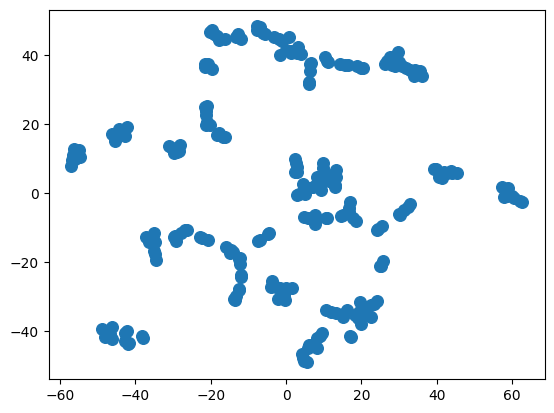

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def visualize(Z):
    z = TSNE(n_components=2, perplexity = 5).fit_transform(Z)
    _ = plt.scatter(z[:, 0], z[:, 1], s=70)

model.eval()
with torch.no_grad():
    node_embeddings = model.encode(data.x, data.edge_index)  # shape: [num_nodes, embedding_dim]
visualize(node_embeddings)

It looks like there is some strong clustering. Let's extract clusters using kNN.

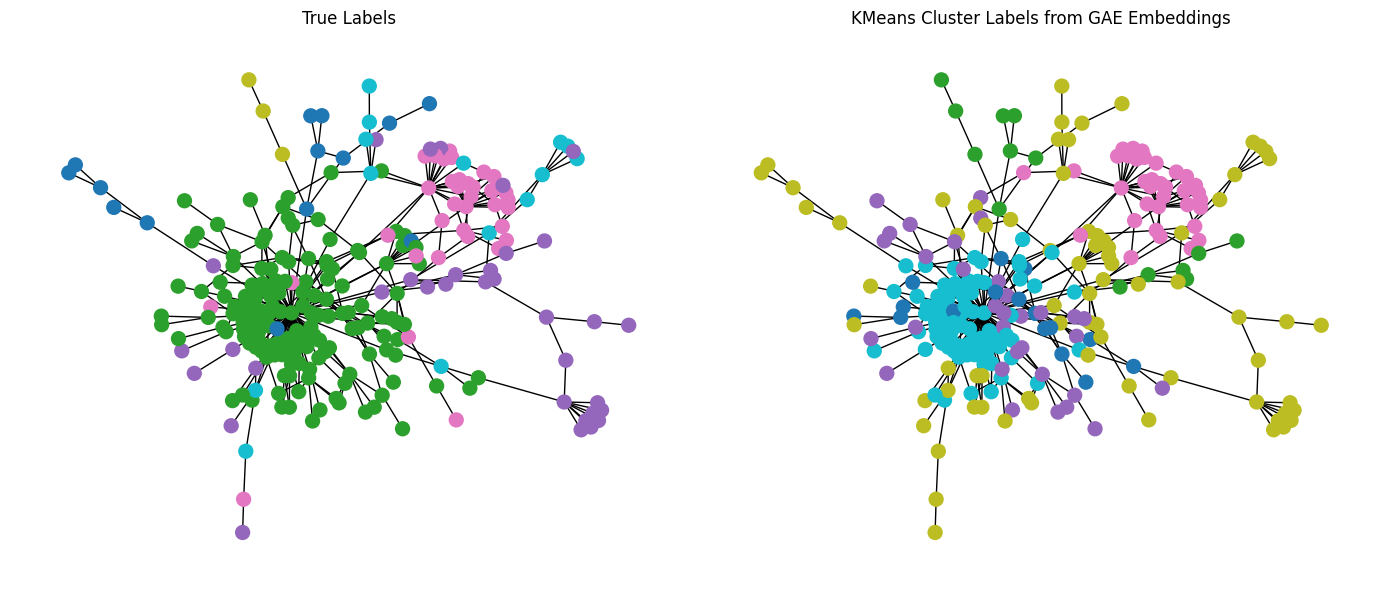

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans

# Step 1: Run KMeans on the learned embeddings z
kmeans = KMeans(n_clusters=6, init="random", n_init=10, random_state=1234)
cluster_labels = kmeans.fit_predict(node_embeddings.cpu().numpy())  # Assuming z is a torch tensor

# Step 2: Prepare layout and coloring
G_draw = G_sub.copy()
pos = nx.spring_layout(G_draw, seed=42)

true_labels = data.y.cpu().numpy()  # Ground truth labels from PyG Data object

# Step 3: Plot side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Ground Truth Labels ---
nx.draw(
    G_draw, pos, node_color=true_labels, cmap=plt.cm.tab10,
    node_size=100, ax=axes[0], with_labels=False
)
axes[0].set_title("True Labels")

# --- Plot 2: KMeans Cluster Labels ---
nx.draw(
    G_draw, pos, node_color=cluster_labels, cmap=plt.cm.tab10,
    node_size=100, ax=axes[1], with_labels=False
)
axes[1].set_title("KMeans Cluster Labels from GAE Embeddings")

plt.tight_layout()
plt.show()

Assign a score to see how well we did.

In [15]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(data.y.cpu().numpy(), cluster_labels)
print(f"Adjusted Rand Index (ARI) comparing clusters to true labels: {ari:.4f}")

Adjusted Rand Index (ARI) comparing clusters to true labels: 0.2164


---
---

#### Using Graph Convolution Neural Network

The Cora dataset includes its own feature vector. 

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score

# Step 1: Prepare node features and labels
X = nodes.iloc[:, 1:-1].values  # 1433 BoW features
y = nodes["subject"]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Map paper_id to index
paper_id_to_idx = {paper_id: i for i, paper_id in enumerate(nodes["paper_id"])}

# Build edge index for subgraph
ordered_nodes = list(G_sub.nodes())
node_to_index = {node_id: i for i, node_id in enumerate(ordered_nodes)}
edge_list = [
    [node_to_index[src], node_to_index[dst]]
    for src, dst in G_sub.edges()
    if src in node_to_index and dst in node_to_index
]
edge_index = torch.tensor(edge_list, dtype=torch.long).T

# Build node feature matrix and label vector (aligned with ordered_nodes)
X_sub = torch.tensor([X[paper_id_to_idx[n]] for n in ordered_nodes], dtype=torch.float)
y_sub = torch.tensor([y_encoded[paper_id_to_idx[n]] for n in ordered_nodes], dtype=torch.long)

data = Data(x=X_sub, edge_index=edge_index, y=y_sub)



Set up a graph convolutional neural network that uses the feature vectors but no other training data.

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden1)
        self.conv2 = GCNConv(hidden1, hidden2)
        self.conv3 = GCNConv(hidden2, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

# Step 3: Initialize model and compute embeddings
model = GCNEncoder(
    in_channels=X_sub.shape[1],   # 1433
    hidden1=256,
    hidden2=128,
    out_channels=64
)

model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index)  # Output shape: [250, 64]


Visualize whether the result is likely to cluster

In [ ]:
visualize(node_embeddings)

Show the graphs side by side

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans

# Step 1: Cluster the GCN embeddings
kmeans_gcn = KMeans(n_clusters=6, init="random", n_init=10, random_state=1234)
cluster_labels_gcn = kmeans_gcn.fit_predict(node_embeddings.cpu().numpy())

# Step 2: Use same layout as GAE plot
G_draw = G_sub.copy()
pos = nx.spring_layout(G_draw, seed=42)

true_labels = data.y.cpu().numpy()  # ground truth class labels

# Step 3: Plot GCN clustering vs. true labels
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Ground truth labels
nx.draw(
    G_draw, pos, node_color=true_labels, cmap=plt.cm.tab10,
    node_size=100, ax=axes[0], with_labels=False
)
axes[0].set_title("True Labels")

# Plot 2: GCN cluster labels
nx.draw(
    G_draw, pos, node_color=cluster_labels_gcn, cmap=plt.cm.tab10,
    node_size=100, ax=axes[1], with_labels=False
)
axes[1].set_title("KMeans Cluster Labels from GCN Embeddings")

plt.tight_layout()
plt.show()

In [ ]:
# Step 5: Evaluate cluster quality vs. ground truth
ari = adjusted_rand_score(y_sub.cpu().numpy(), cluster_labels_gcn)
print(f"Adjusted Rand Index (ARI) comparing clusters to true labels: {ari:.4f}")

---
---

#### Adding semi-supervised learning to the GCN

Let's begin by creating a training set that uses about 10% of the nodes in the graph. I want the training samples to be roughly balanced across paper types.

In [ ]:
import numpy as np
from collections import defaultdict

# Step 1: Build training mask with ~10% nodes (balanced across classes)
num_classes = len(set(y_sub.tolist())) + 1
num_total = len(y_sub)
num_train = int(0.1 * num_total)

# Group indices by class
class_indices = defaultdict(list)
for i, label in enumerate(y_sub.tolist()):
    class_indices[label].append(i)

# Sample evenly from each class
samples_per_class = num_train // num_classes
train_indices = []

for label, indices in class_indices.items():
    np.random.seed(42)
    np.random.shuffle(indices)
    train_indices.extend(indices[:samples_per_class])

# Build training mask
train_mask = torch.zeros(num_total, dtype=torch.bool)
train_mask[train_indices] = True
data.train_mask = train_mask

Set up the GCN to do learning, but with classifier error.

In [ ]:
# Define GCN with classifier output
class GCNClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden1)
        self.conv2 = GCNConv(hidden1, hidden2)
        self.conv3 = GCNConv(hidden2, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

# Instantiate model
model = GCNClassifier(in_channels=data.num_node_features, hidden1=256, hidden2=128, out_channels=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train only on labeled nodes
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        model.eval()
        pred = out.argmax(dim=1)
        acc = (pred == data.y).float().mean().item()
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | Acc (overall): {acc:.4f}")

Visualize results, comparing what happens when we use the embedding plus some clusters to what happens when we just run the classifier.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans

# Extract embeddings (use softmax output or conv2 layer as embedding)
model.eval()
with torch.no_grad():
    z = model(data)

# --- Clustering on embeddings ---
kmeans = KMeans(n_clusters=num_classes, random_state=0)
cluster_labels = kmeans.fit_predict(z.cpu().numpy())

# --- Classification prediction ---
predicted_labels = z.argmax(dim=1).cpu().numpy()

# --- Visualization ---
G_draw = G_sub.copy()
pos = nx.spring_layout(G_draw, seed=42)

true_labels = data.y.cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

nx.draw(G_draw, pos, node_color=true_labels, cmap=plt.cm.tab10, node_size=100, ax=axes[0], with_labels=False)
axes[0].set_title("True Labels")

nx.draw(G_draw, pos, node_color=cluster_labels, cmap=plt.cm.tab10, node_size=100, ax=axes[1], with_labels=False)
axes[1].set_title("KMeans Clusters on GCN Embeddings")

nx.draw(G_draw, pos, node_color=predicted_labels, cmap=plt.cm.tab10, node_size=100, ax=axes[2], with_labels=False)
axes[2].set_title("GCN Predicted Labels (argmax)")

plt.tight_layout()
plt.show()

Look at the ARI score to see if things have improved

In [ ]:
# ARI: KMeans on GCN embeddings
ari_kmeans = adjusted_rand_score(true_labels, cluster_labels)

# ARI: Classifier predictions
ari_classifier = adjusted_rand_score(true_labels, predicted_labels)

print(f"Adjusted Rand Index (KMeans on embeddings): {ari_kmeans:.4f}")
print(f"Adjusted Rand Index (GCN predicted labels): {ari_classifier:.4f}")

---
---

#### Interpreting ARI

The Adjusted Rand Index measures how similar two clusterings are — correcting for random chance.

	•	It compares two partitions of the same data:

Predicted cluster labels vs. ground truth class labels
	•	It considers how many pairs of points are clustered together in both or neither groupings.

**Adjusted Rand Index (ARI) Interpretation**

| ARI Score | Interpretation                       |
|-----------|--------------------------------------|
| **1.0**   | Perfect match with true labels       |
| 0.8–0.9   | Excellent clustering                  |
| 0.5–0.7   | Good structure, moderate alignment    |
| 0.2–0.4   | Weak clustering, some structure       |
| **0.0**   | No better than random assignment      |
| **< 0.0** | Worse than random (actively misleading) |